## Brick Alignment Check

#### General Description:
The bond or joint pattern of a masonry wall can have a significant influence on its flexural strength. The brick alignment classifier will check for the bond pattern in walls from wall images. Specifically, the classifier will distinguish between a compliant or a non-compliant wall, as defined on the basis of its proximity to a running bond or a stack bond respectively, as shown in the images below

<img src="img/alignmentcheck.png" width=300 height=300 >
<!-- <img src="wallnogo.png" width=125 height=125, img align="left" > -->

#### Threshold for compliance:
For a wall to be compliant on the basis of this check, the head joints in the successive rows of bricks should be horizontally offset by at least one quarter the unit length

#### Methodology of Check:
The current methodology setup for checking the bond pattern is as follows:
1. Process a wall image to get contours of bricks (Segmentation technique TBD)
2. From the contours, obtain the centroid point of each brick
3. Group the centroids corresponding to each row of bricks (approximated by comparing the y coordinate of centroid points)
4. Calculate the difference in x coordinates of successive rows
5. Divide the difference by the average unit length of the bricks being compared
6. If the horizontal offset is less than 0.25, the image is classified as "No Go", otherwise "Go"

#### Outputs:
 - “Go” or “No Go” label for compliant and non-compliant bond pattern respectively
 - The original image with the non-compliant rows highlighted
 - Overall score and percentage of compliant rows with respect to all the rows

#### Constraints
For the classifier to correctly identify the bond pattern, the input images submitted to the mobile app should meet the following requirements:
 - The input image should be cropped to show just the bricks and bond pattern (with the windows cropped out for instance)
 - If more than one wall is being checked at a time, a separate photo should be taken for each wall

***

## Step 1: Image Processing
In this check, the input images are processed in order to detect the bricks for further analysis

### Reusable methods
 - **Load Images**: Get all filepaths
 - **Display Images**: Display one, two, or multiple images
 - **Change Image Format**: Change image format to RGB, HSV, gray etc.
 - **Get Centroids**: Get centroids of bricks from a threshold image

#### Load Images

In [1]:
import os
import random


### CHANGE THE DIRECTORY PATH TO THE FOLDER WITH TEST IMAGES
dirpath = "G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM"+"/"

def loadImages(dirpath):
    filepaths  = [dirpath+file for file in os.listdir(dirpath)]
    random.shuffle(filepaths)
    return filepaths

#### Display images

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# Display one image
def display_one(a, title1 = "Original", mode=None):
    plt.imshow(a,mode), plt.title(title1)
    plt.show()
    
# Display two images
def display_two(a, b, title1 = "Original", title2 = "Edited",mode=None):
    plt.subplot(121), plt.imshow(a,mode), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b,mode), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display multiple images
def display_many(images,titles,mode=None):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 3, plt_idx)
        plt.title(titles[i])
        plt.imshow(img,mode)
    plt.show()

#### Change Image Format

In [3]:
import cv2

def convert2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def convert2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convert2hsv(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2HSV) 

#### Get Centroids

In [4]:
def getcentroids(img,thresh): #Inputs: Original Image, Threshold Image

    # FIND CONTOURS
    contours_ag,h = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
#     fraction =img.shape[0:2][0]/6
#     print(fraction)

    centroids = []
    cXs = []
    cYs = []
    
    for c in contours_ag:
        area = cv2.contourArea(c)

        if area > 100:
            (x, y, w, h) = cv2.boundingRect(c)

            # Draw the contours
            #cv2.drawContours(img, [c], -1, (0, 255, 0), 2)

            # Get random color for each brick
            tpl = tuple([random.randint(0, 255) for _ in range(3)])
            cv2.rectangle(img, (x, y), (x + w, y + h), tpl, -1)
            
            # calculate moments for each contour
            M = cv2.moments(c)
        
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append([cX,cY])
            cXs.append(cX)
            cYs.append(cY)
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)            
            
    #Display Images
    display_two(thresh,img,title1="THRESHOLD",title2="CENTROIDS FROM CONTOURS",mode="gray")
    print("No. of Centroids: ",len(centroids))
    

    return centroids

***
### Process Images



#### 1.1 Thresholding & Centroid Extraction
 - Apply different thresholding techniques to process images
 - Extract centroid from the threshold image

#### Method 1: 
**Convert to HSV, get saturation, & apply adaptive gaussian threshold**

In [5]:
## This method currently works for the BIM Generated Images, but not on the real wall images

def adaptivegaussian(filepath):
    img = cv2.imread(filepath)
    
    # CONVERT TO RGB
    rgb = convert2rgb(img)
    
    #CONVERT TO GRAY
    gray = convert2gray(img)

    
    #CONVERT TO HSV
    hsv = convert2hsv(img)
    
    # GET SATURATION FROM HSV
    S=hsv[:,:,1]
    

    # APPLY ADAPTIVE GAUSSIAN THRESHOLD
    th_ag = cv2.adaptiveThreshold(S,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,11,2)
    
    display_two(rgb,gray,title2="GRAY",mode="gray")
    
    ## GET CENTROIDS
    centroids = getcentroids(rgb,th_ag)
    

#### Method 1 Results:

IMAGE  1 , NAME:  T_BA_NoGo_2057_Gen4_0302_63_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2057_Gen4_0302_63_2.png


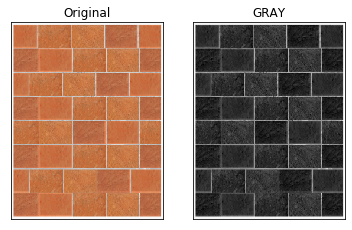

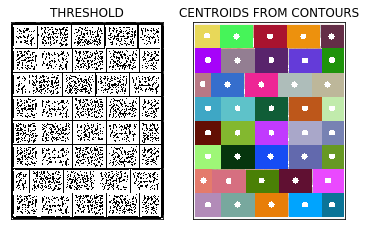

No. of Centroids:  40
IMAGE  2 , NAME:  T_BA_NoGo_2064_Gen4_0302_70_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2064_Gen4_0302_70_2.png


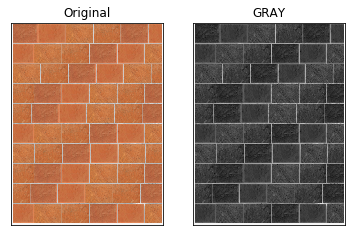

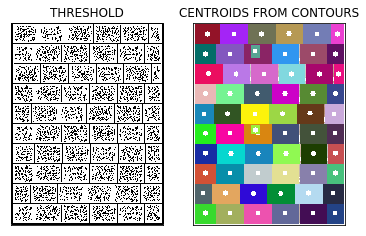

No. of Centroids:  62
IMAGE  3 , NAME:  T_BA_NoGo_2063_Gen4_0302_69_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2063_Gen4_0302_69_2.png


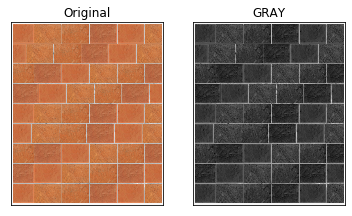

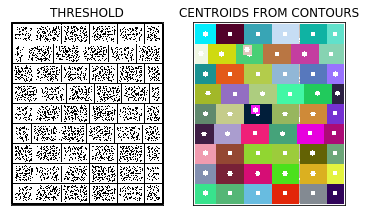

No. of Centroids:  56
IMAGE  4 , NAME:  T_BA_NoGo_2063_Gen4_0302_69_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2063_Gen4_0302_69_1.png


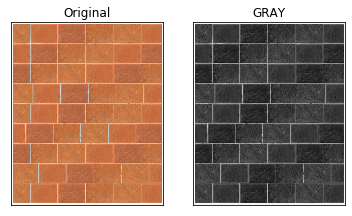

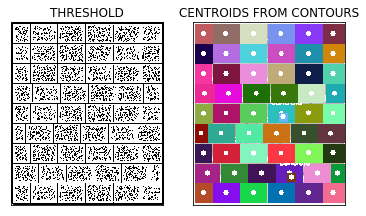

No. of Centroids:  56
IMAGE  5 , NAME:  T_BA_Go_1000_Gen3_0229_306_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1000_Gen3_0229_306_1.png


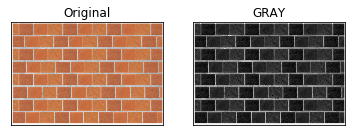

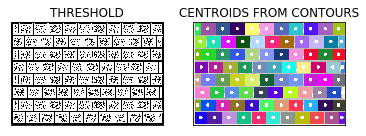

No. of Centroids:  88
IMAGE  6 , NAME:  T_BA_Go_1003_Gen3_0229_309_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1003_Gen3_0229_309_1.png


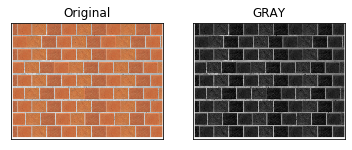

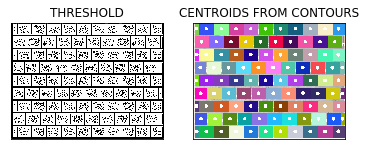

No. of Centroids:  98
IMAGE  7 , NAME:  T_BA_Go_1001_Gen3_0229_307_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1001_Gen3_0229_307_1.png


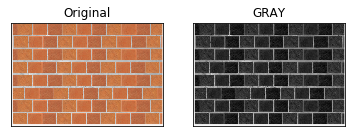

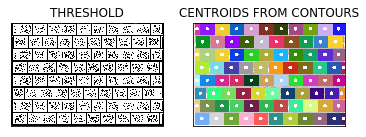

No. of Centroids:  87
IMAGE  8 , NAME:  T_BA_Go_1002_Gen3_0229_308_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1002_Gen3_0229_308_2.png


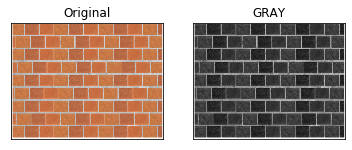

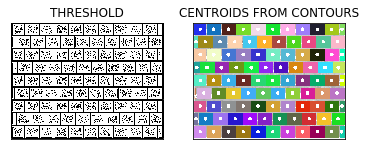

No. of Centroids:  98
IMAGE  9 , NAME:  T_BA_NoGo_2066_Gen4_0302_72_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2066_Gen4_0302_72_0.png


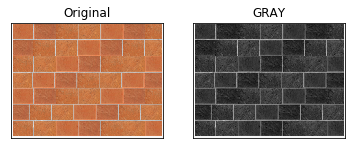

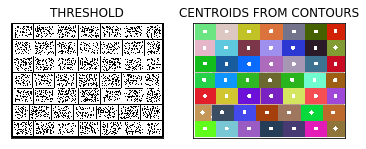

No. of Centroids:  49
IMAGE  10 , NAME:  T_BA_NoGo_2063_Gen4_0302_69_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2063_Gen4_0302_69_0.png


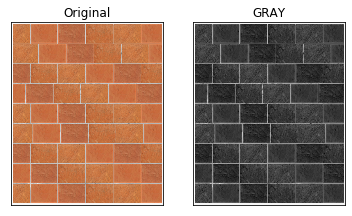

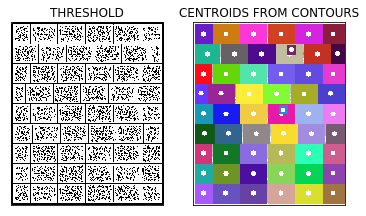

No. of Centroids:  56
IMAGE  11 , NAME:  T_BA_NoGo_2065_Gen4_0302_71_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2065_Gen4_0302_71_0.png


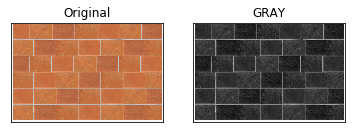

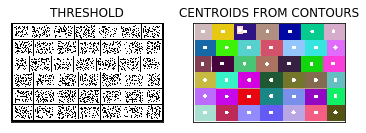

No. of Centroids:  43
IMAGE  12 , NAME:  T_BA_NoGo_2059_Gen4_0302_65_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2059_Gen4_0302_65_0.png


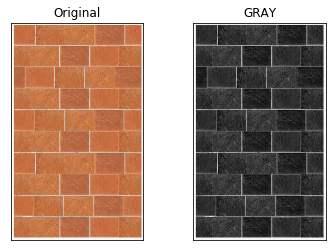

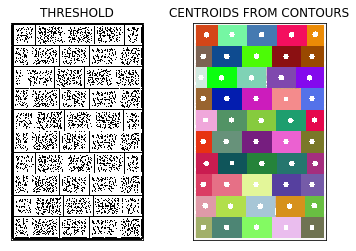

No. of Centroids:  50
IMAGE  13 , NAME:  T_BA_NoGo_2057_Gen4_0302_63_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2057_Gen4_0302_63_1.png


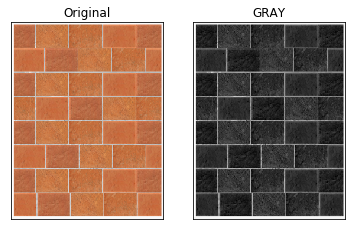

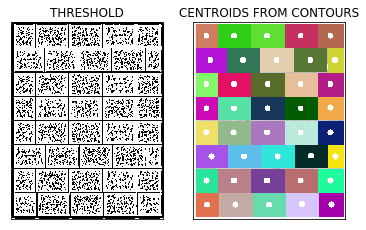

No. of Centroids:  40
IMAGE  14 , NAME:  T_BA_Go_1004_Gen3_0229_31_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1004_Gen3_0229_31_2.png


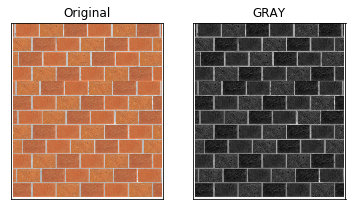

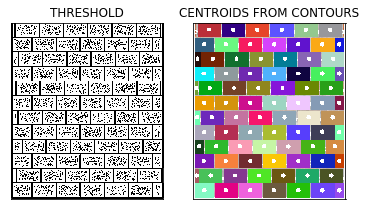

No. of Centroids:  83
IMAGE  15 , NAME:  T_BA_NoGo_2062_Gen4_0302_68_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2062_Gen4_0302_68_2.png


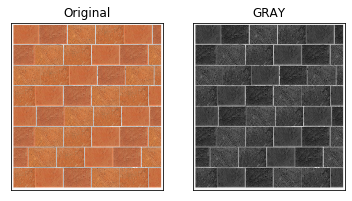

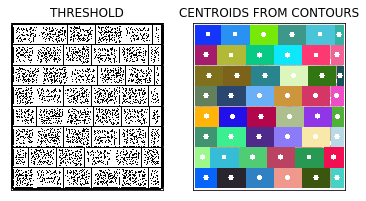

No. of Centroids:  48
IMAGE  16 , NAME:  T_BA_Go_1000_Gen3_0229_306_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1000_Gen3_0229_306_0.png


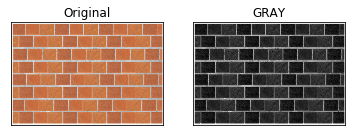

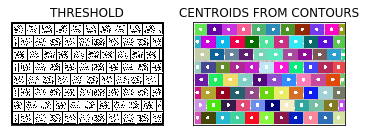

No. of Centroids:  88
IMAGE  17 , NAME:  T_BA_Go_1000_Gen3_0229_306_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1000_Gen3_0229_306_2.png


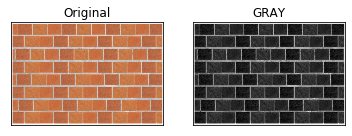

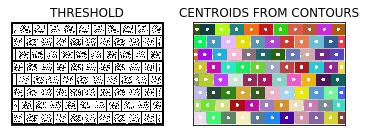

No. of Centroids:  88
IMAGE  18 , NAME:  T_BA_NoGo_2058_Gen4_0302_64_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2058_Gen4_0302_64_2.png


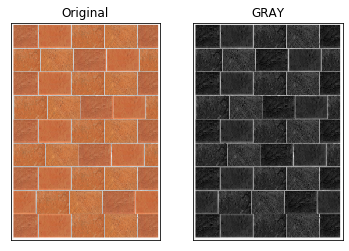

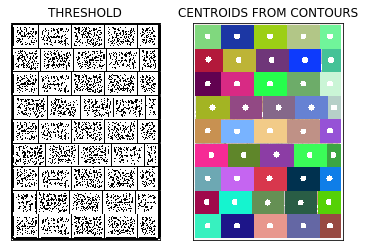

No. of Centroids:  45
IMAGE  19 , NAME:  T_BA_NoGo_2059_Gen4_0302_65_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2059_Gen4_0302_65_1.png


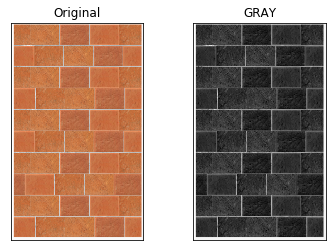

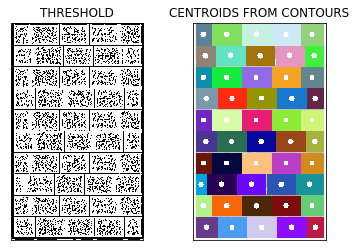

No. of Centroids:  50
IMAGE  20 , NAME:  T_BA_Go_1004_Gen3_0229_31_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1004_Gen3_0229_31_0.png


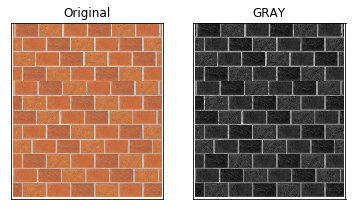

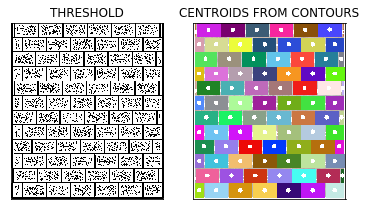

No. of Centroids:  83
IMAGE  21 , NAME:  T_BA_NoGo_2060_Gen4_0302_66_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2060_Gen4_0302_66_0.png


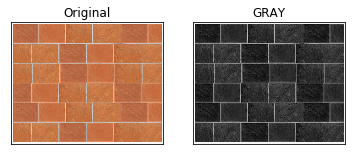

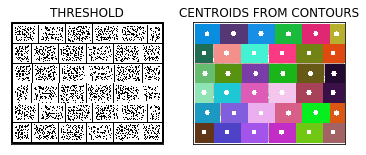

No. of Centroids:  36
IMAGE  22 , NAME:  T_BA_Go_1003_Gen3_0229_309_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1003_Gen3_0229_309_0.png


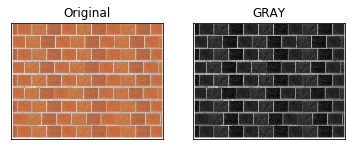

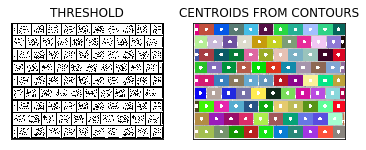

No. of Centroids:  98
IMAGE  23 , NAME:  T_BA_Go_1002_Gen3_0229_308_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1002_Gen3_0229_308_0.png


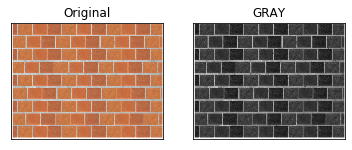

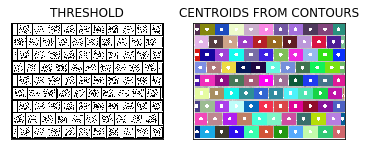

No. of Centroids:  98
IMAGE  24 , NAME:  T_BA_NoGo_2065_Gen4_0302_71_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2065_Gen4_0302_71_2.png


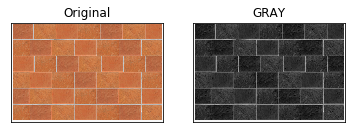

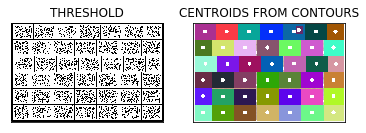

No. of Centroids:  43
IMAGE  25 , NAME:  T_BA_NoGo_2064_Gen4_0302_70_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2064_Gen4_0302_70_1.png


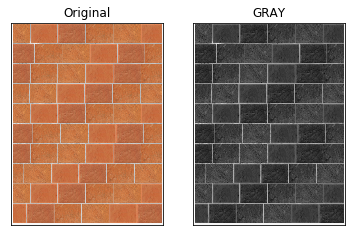

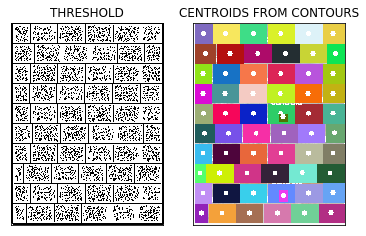

No. of Centroids:  62
IMAGE  26 , NAME:  T_BA_NoGo_2060_Gen4_0302_66_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2060_Gen4_0302_66_2.png


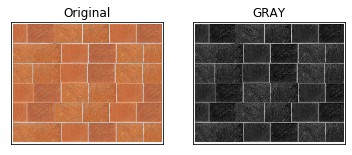

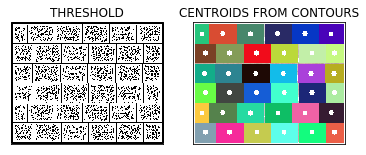

No. of Centroids:  36
IMAGE  27 , NAME:  T_BA_NoGo_2062_Gen4_0302_68_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2062_Gen4_0302_68_1.png


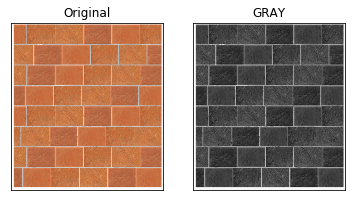

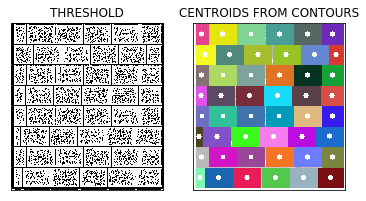

No. of Centroids:  48
IMAGE  28 , NAME:  T_BA_NoGo_2064_Gen4_0302_70_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2064_Gen4_0302_70_0.png


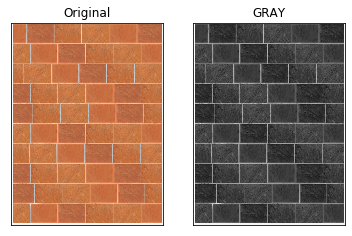

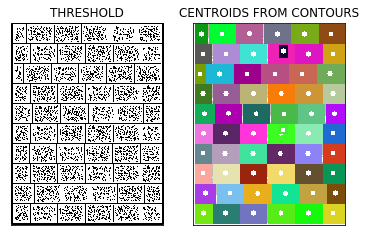

No. of Centroids:  62
IMAGE  29 , NAME:  T_BA_NoGo_2057_Gen4_0302_63_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2057_Gen4_0302_63_0.png


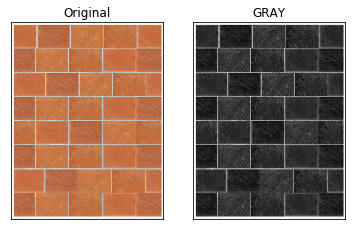

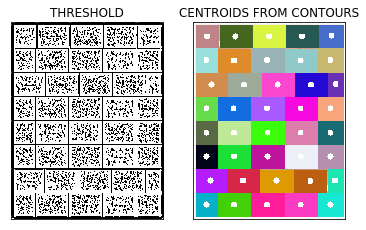

No. of Centroids:  40
IMAGE  30 , NAME:  T_BA_Go_1001_Gen3_0229_307_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1001_Gen3_0229_307_2.png


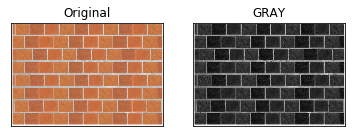

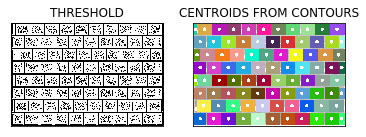

No. of Centroids:  87
IMAGE  31 , NAME:  T_BA_NoGo_2059_Gen4_0302_65_2.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2059_Gen4_0302_65_2.png


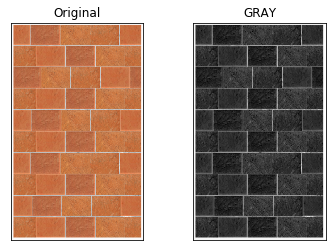

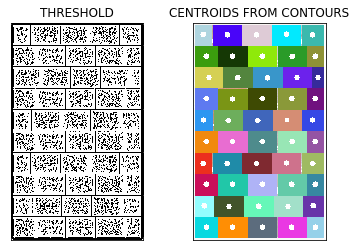

No. of Centroids:  50
IMAGE  32 , NAME:  T_BA_Go_1004_Gen3_0229_31_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_Go_1004_Gen3_0229_31_1.png


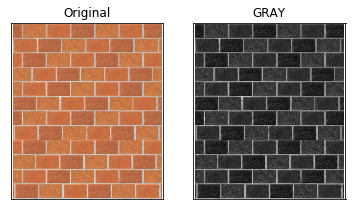

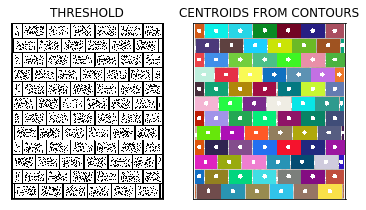

No. of Centroids:  83
IMAGE  33 , NAME:  T_BA_NoGo_2058_Gen4_0302_64_0.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2058_Gen4_0302_64_0.png


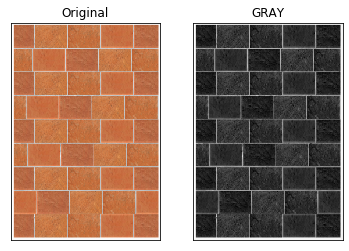

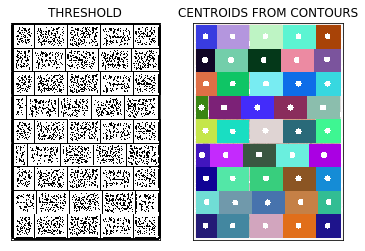

No. of Centroids:  45
IMAGE  34 , NAME:  T_BA_NoGo_2060_Gen4_0302_66_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2060_Gen4_0302_66_1.png


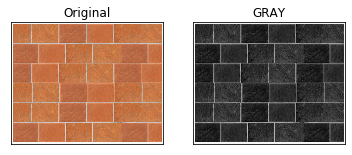

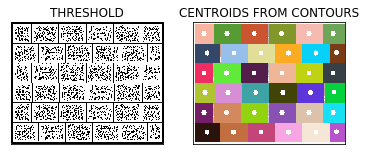

No. of Centroids:  36
IMAGE  35 , NAME:  T_BA_NoGo_2058_Gen4_0302_64_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2058_Gen4_0302_64_1.png


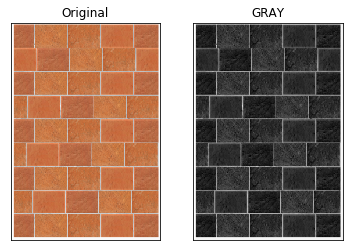

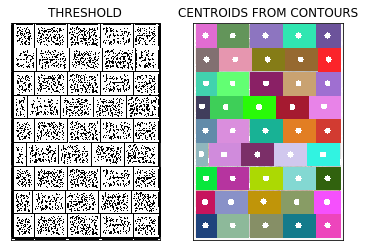

No. of Centroids:  45
IMAGE  36 , NAME:  T_BA_NoGo_2065_Gen4_0302_71_1.png 
PATH: G:/My Drive/BuildChange/ISAC-SIMO/Block Alignment/TestImages_BIM/T_BA_NoGo_2065_Gen4_0302_71_1.png


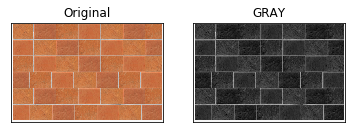

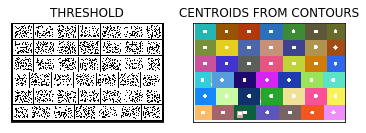

No. of Centroids:  43


In [10]:
### BIM IMAGES

global dirpath
def main(dirpath):  
    bimimagespath = loadImages(dirpath)
    for i,filepath in enumerate(bimimagespath):
        print("IMAGE ",i+1,", NAME: ",os.path.basename(filepath), "\nPATH:",filepath)
        centroids = adaptivegaussian(filepath)
main(dirpath)

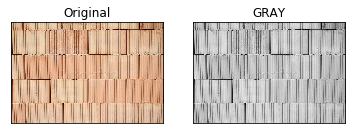

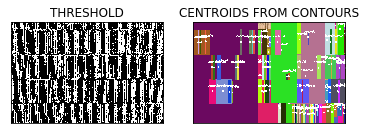

No. of Centroids:  197


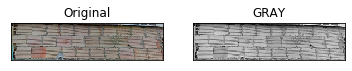

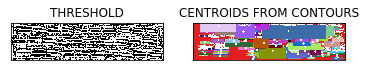

No. of Centroids:  186


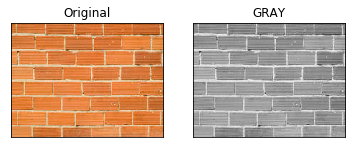

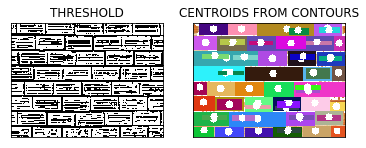

No. of Centroids:  60


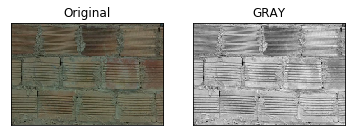

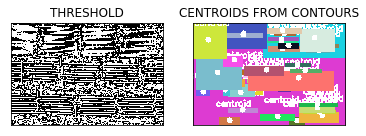

No. of Centroids:  43


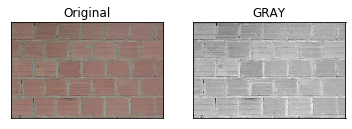

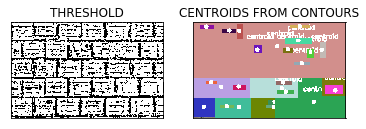

No. of Centroids:  31


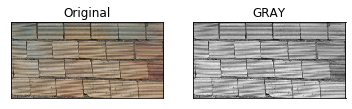

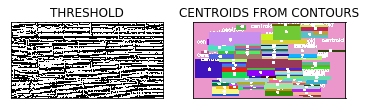

No. of Centroids:  101


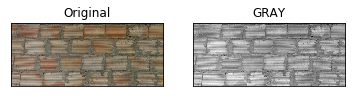

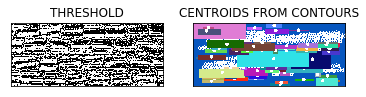

No. of Centroids:  86


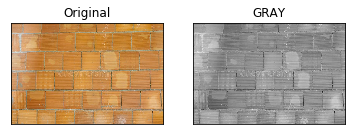

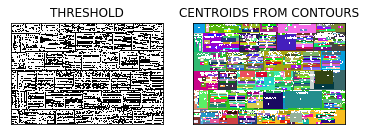

No. of Centroids:  571


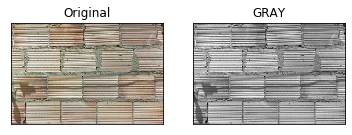

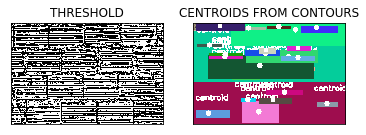

No. of Centroids:  43


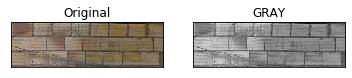

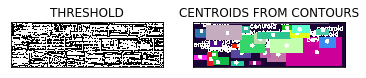

No. of Centroids:  38


In [11]:
# REAL WALL IMAGES
path = "C:/Users/NFT Build Change/Desktop/Colombia/Git Repo ISAC-SIMO/ISAC-SIMO/Notebooks/Test Images Real Walls"+"/"
import os
import random
realimagespath = loadImages(path)
random.shuffle(realimagespath)
for i,filepath in enumerate(realimagespath[0:10]):
    centroids = adaptivegaussian(filepath)

#### Method 2:

### Step 2: Calculate horizontal offsets from centroids

#### Step 2.1: Group centroids by row
The first step in 2.1 is to group the centroid points by rows. This can be done by comparing the y coordinate of centroid points